# EDA For Kaggle Competition 

Following the excellent kernal on kaggel (https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-sberbank) to understand the data better, to explore further and give us a path start. To start out this is going to be a spot on copy of the linked project. 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [16]:
import scipy as sp

In [17]:
import sklearn
print sklearn.__version__

0.18.1


Importing the train file and understanding the data. 

In [18]:
train_df =  pd.read_csv("train.csv")
train_df.shape

(30471, 292)

The train data has 30471 rows and 292 columns. That's a lot of features! 

In [19]:
train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

There are a ton of variables!  Let's look at the target variable first since that is what one should do! 

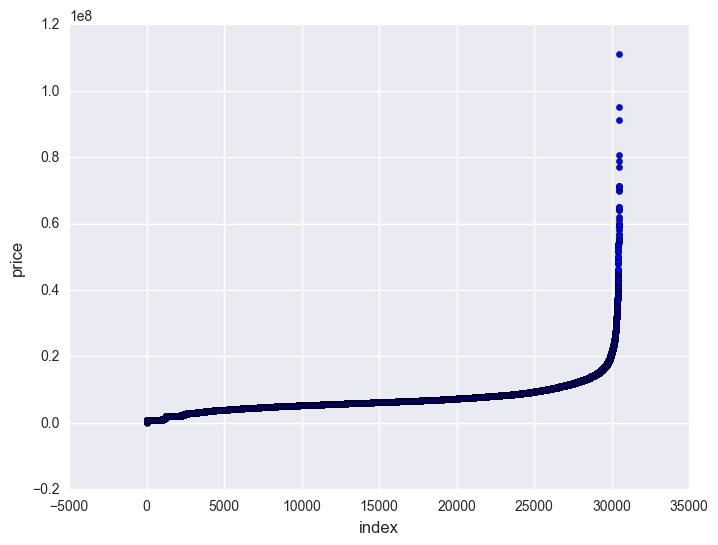

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

Let's look at the distribution of the target variable. 

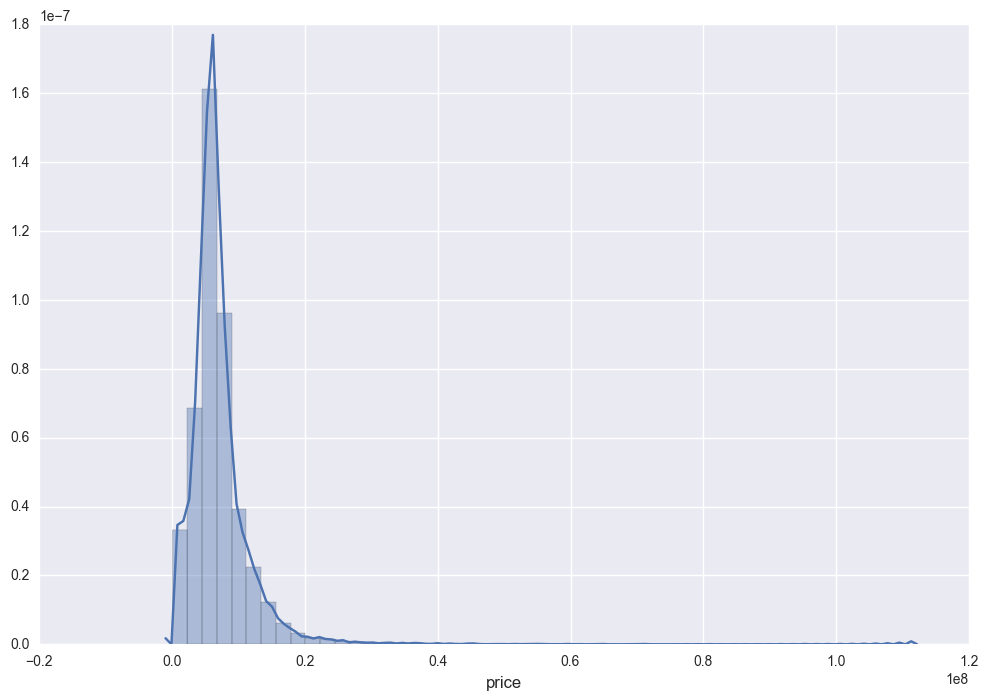

In [21]:
plt.figure(figsize = (12,8))
sns.distplot(train_df.price_doc.values, bins=50, kde = True)

plt.xlabel('price', fontsize = 12)
plt.show()

This is not a very normal distribution. Certainly a very long right tail. Since our metric is Root Mean Square Logarithmic error, let us plot the log of price_doc variable. So let's take the log transform 

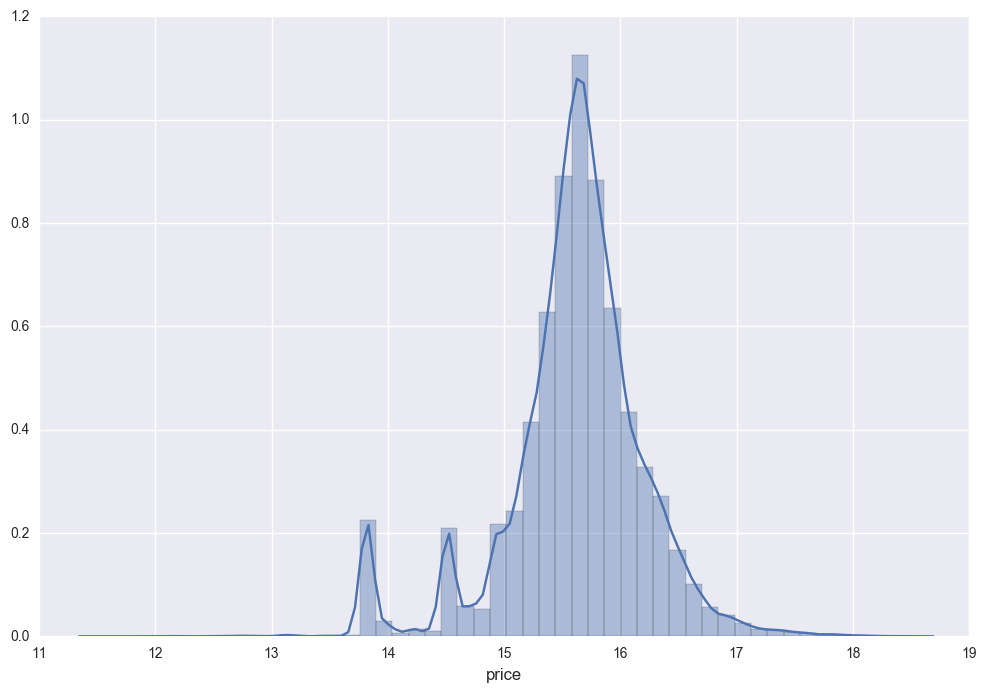

In [22]:
plt.figure(figsize= (12,8))
sns.distplot(np.log(train_df.price_doc.values), bins=50, kde=True)
plt.xlabel('price', fontsize =12)
plt.show()

This is a much better distribution than before. Now let us look at how the median housing price change with time. 

In [23]:
train_df['yearmonth'] = train_df['timestamp'].apply(lambda x: x[:4]+x[5:7])
grouped_df = train_df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()

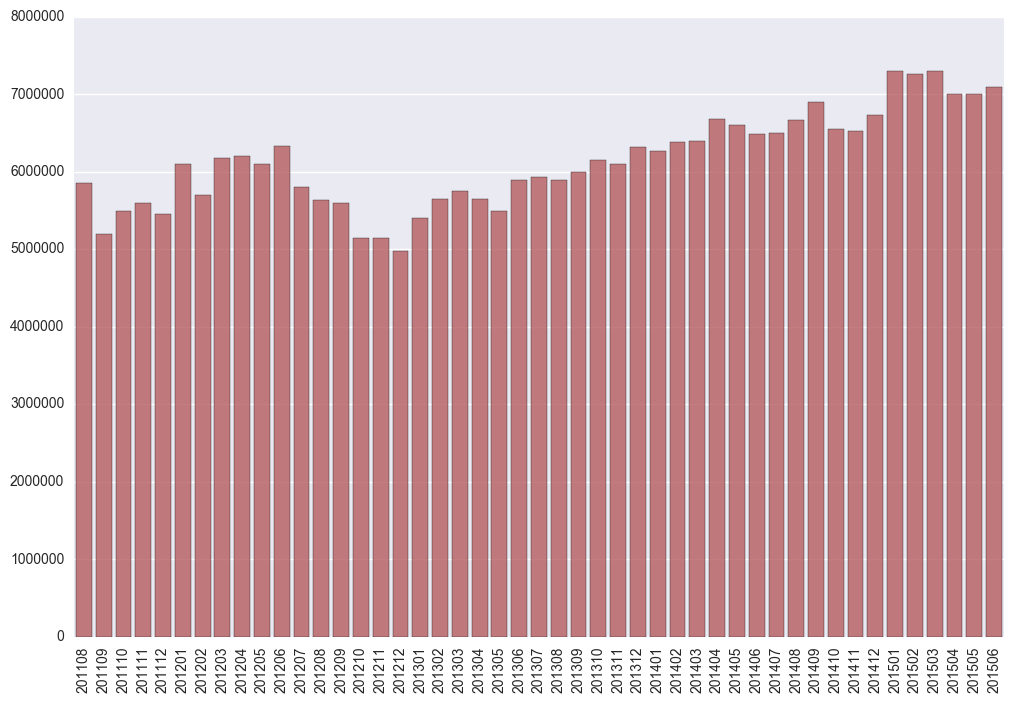

In [24]:
plt.figure(figsize=(12,8))
sns.barplot(grouped_df.yearmonth.values, grouped_df.price_doc.values, alpha=0.8, color=color[2])
plt.xticks(rotation='vertical')
plt.show()

There are some variations in the median price with respect to time. Towards the end, there appears to be some linear increase in the price values. The data time line extends from August 2011 to June 2015. 


Now lets look into some other variable and see what we find. 

In [25]:
train_df = pd.read_csv("train.csv", parse_dates=['timestamp']) 
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column_Type"]
dtype_df.groupby("Column_Type").aggregate('count').reset_index()
# OK this is a cool method to find the number of dtypes in a DF 

,Column_Type,Count
0,int64,157
1,datetime64[ns],1
2,float64,119
3,object,15


So a majority of them are numerical variables with 15 variables and 1 date variable. Lets explore the number of missing values in each column. Note: there are 30471 rows. 

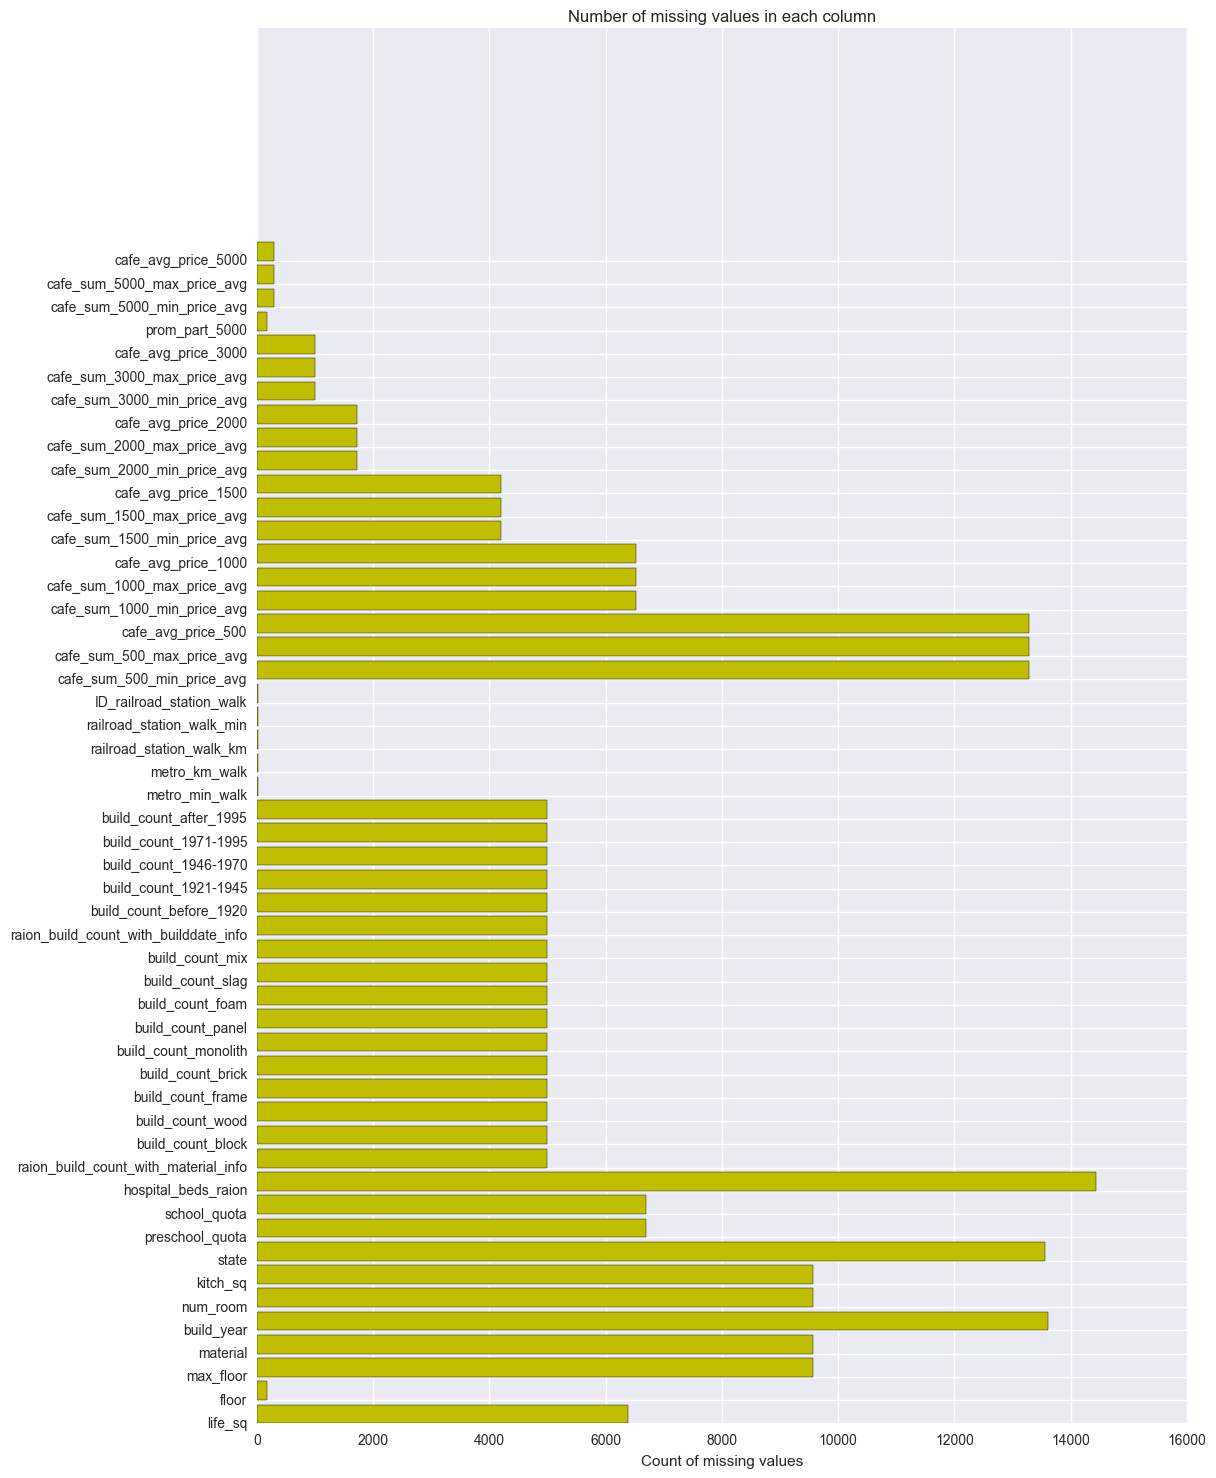

In [26]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count'] > 0]
ind = np.arange(missing_df.shape[0])
width =  0.9 
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color ='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()
# OK this is cool way to display missing values

In [27]:
for f in train_df.columns: 
    if train_df[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))
train_y = train_df.price_doc.values
train_X = train_df.drop(["id","timestamp","price_doc"], axis = 1)

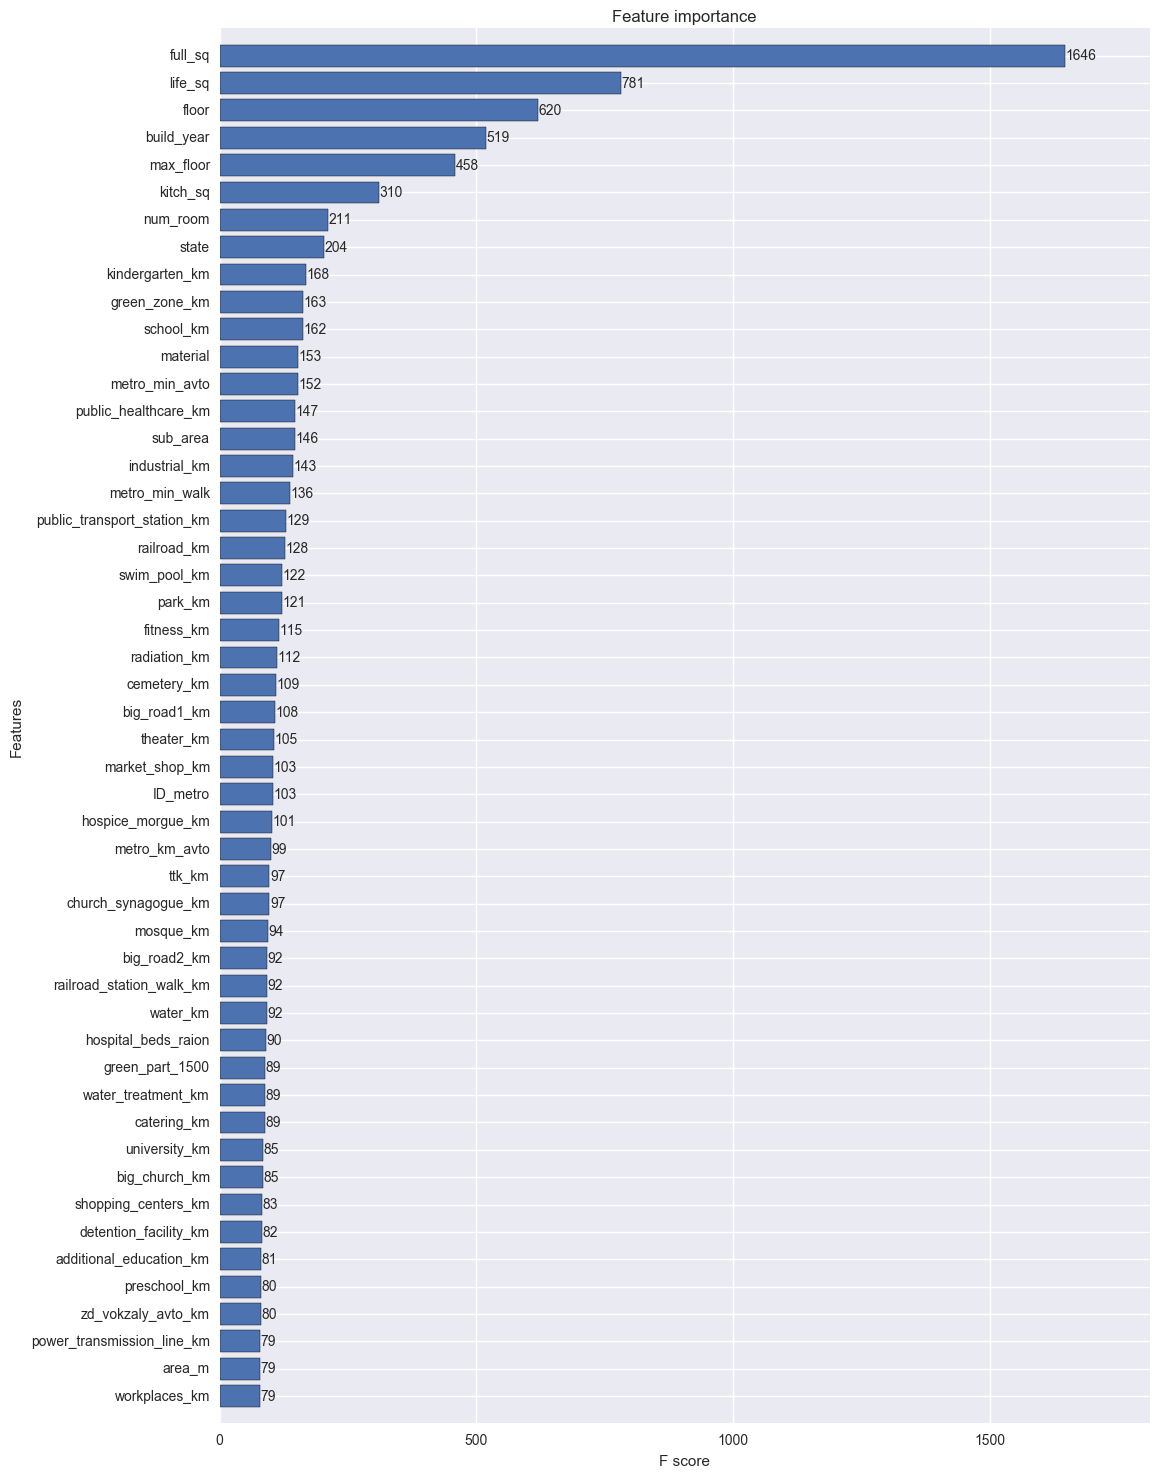

In [28]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

The above plot is the F-score (look that up) as a function of the features and tells us the importance of the features. The top 15 features (in order) are: 

1) full_sq: total area in square meters, including loggias, balconies and other non-residential areas

2) life_sq: living area in square meters, excluding loggias, balconies and other non-residential areas

3) floor: for apartments, floor of the building

4) build_year: year built

5) max_floor: number of floors in the building

6) kitch_sq: kitchen area

7) num_room: number of living rooms

# 8) state: apartment condition

# 9) kindergarten_km	Distance to kindergarten

# 10) green_zone_km:	Distance to green zone or Below

11) school_km	Distance to high school 

12) material: wall material

13) metro_min_avto:	Time to subway by car, min.

14) public_healthcare_km	Distance to public healthcare

15) sub_area: name of the district

16) industrial_zone_km	Distance to industrial zone

17) metro_min_walk	Time to metro by foot

18) public_healthcare_km	Distance to public healthcare

19) railroad_km	Distance to the railway / Moscow Central Ring / open areas Underground

20) swim_pool_km	Distance to swimming pool

## Coming Back to look at these variables and To Clean Them
## For now let's move forward with the kernel and LEARN! 


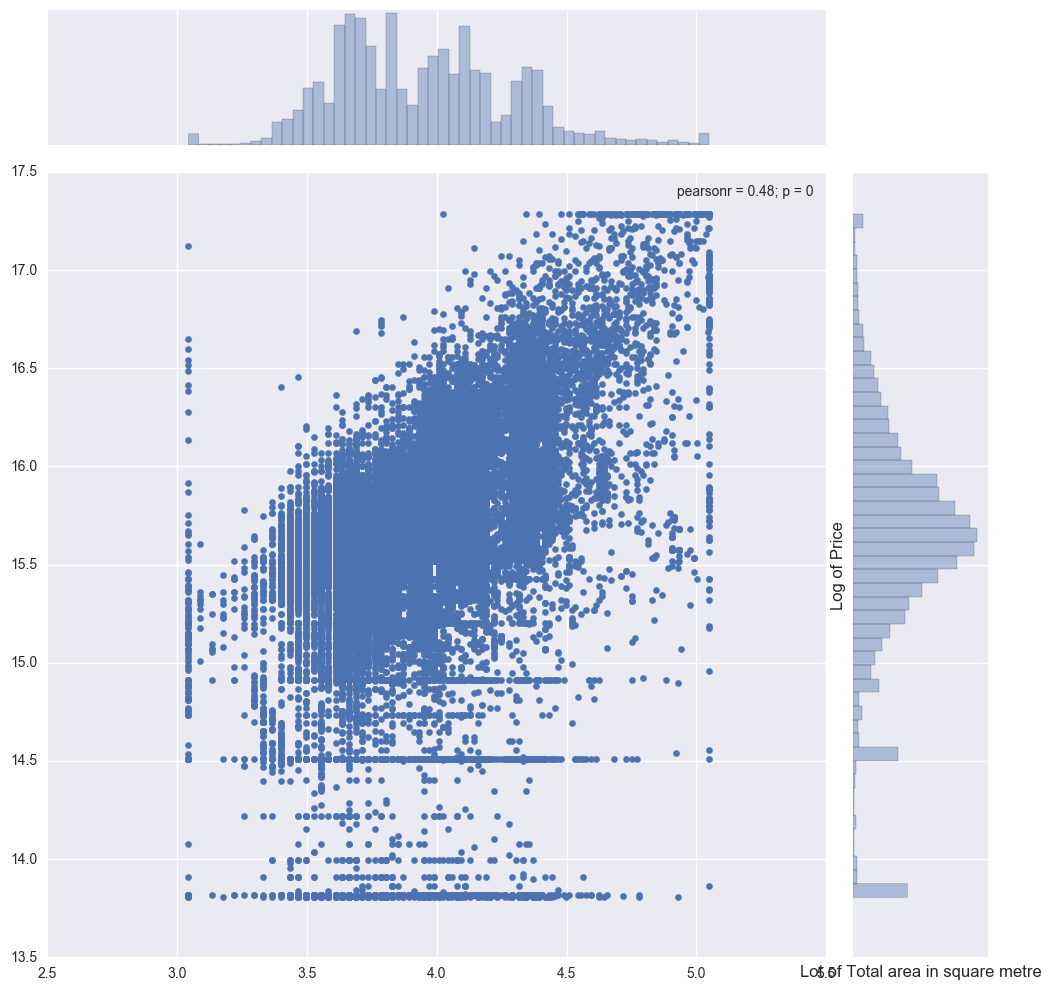

In [29]:
ulimit = np.percentile(train_df.price_doc.values,99.5) # I think is to deal with price outliers
llimit = np.percentile(train_df.price_doc.values,0.5)
train_df['price_doc'].ix[train_df['price_doc']> ulimit] = ulimit
train_df['price_doc'].ix[train_df['price_doc']< llimit] = llimit

col = "full_sq"
ulimit = np.percentile(train_df[col].values, 99.5) # again resetting low and high outliers. 
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12)) # log1p:  Calculates ``log(1 + x)``.
sns.jointplot(x=np.log1p(train_df.full_sq.values), y=np.log1p(train_df.price_doc.values), size=10)
plt.ylabel('Log of Price', fontsize = 12)
plt.xlabel('Lot of Total area in square metre', fontsize =12) # the log of the area doesn't look gaussian
plt.show()

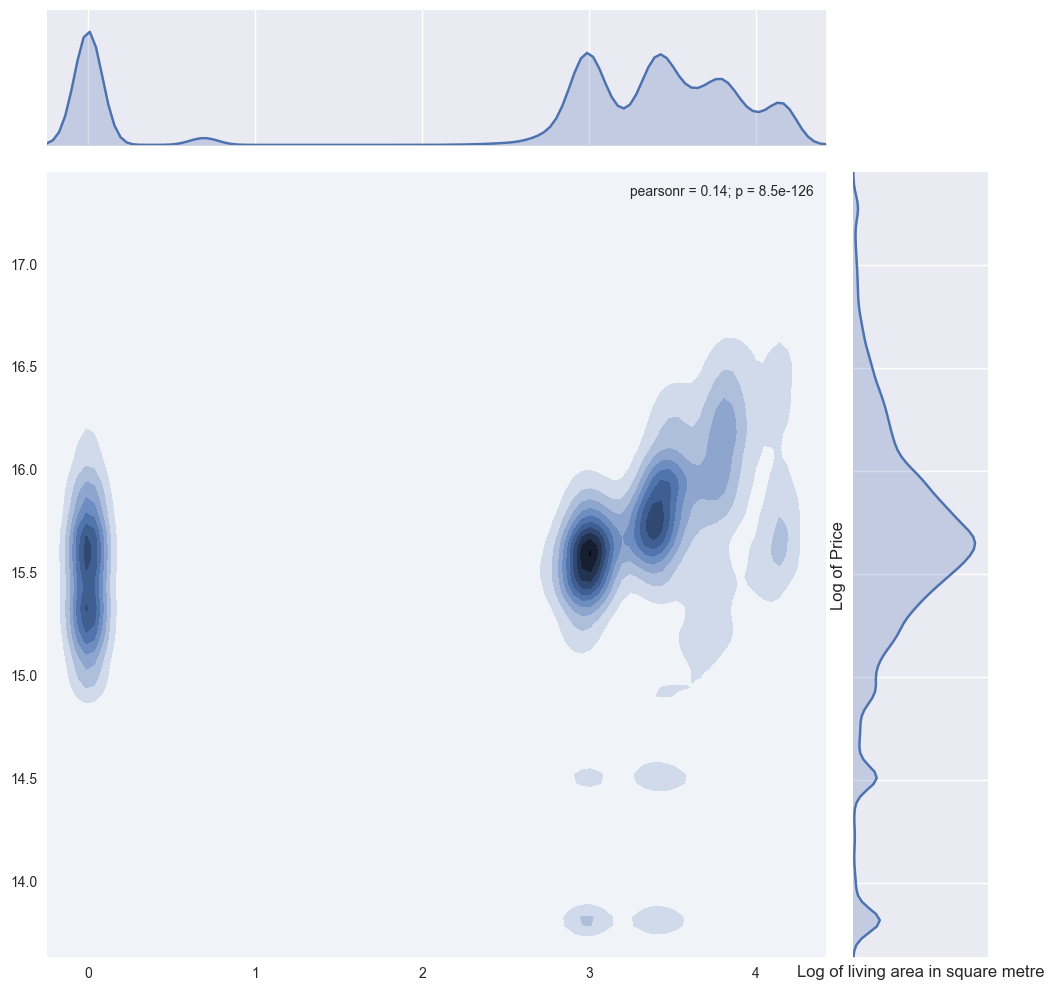

In [30]:
col = "life_sq"
train_df[col].fillna(0,inplace = True)
ulimit = np.percentile(train_df[col].values,95)
llimit = np.percentile(train_df[col].values, 5)
train_df[col].ix[train_df[col] > ulimit] = ulimit
train_df[col].ix[train_df[col] < llimit] = llimit

plt.figure(figsize = (12,12))
sns.jointplot(x=np.log1p(train_df.life_sq.values), y = np.log1p(train_df.price_doc.values), kind='kde', size=10)
plt.ylabel('Log of Price', fontsize = 12)
plt.xlabel('Log of living area in square metre', fontsize=12)
plt.show()

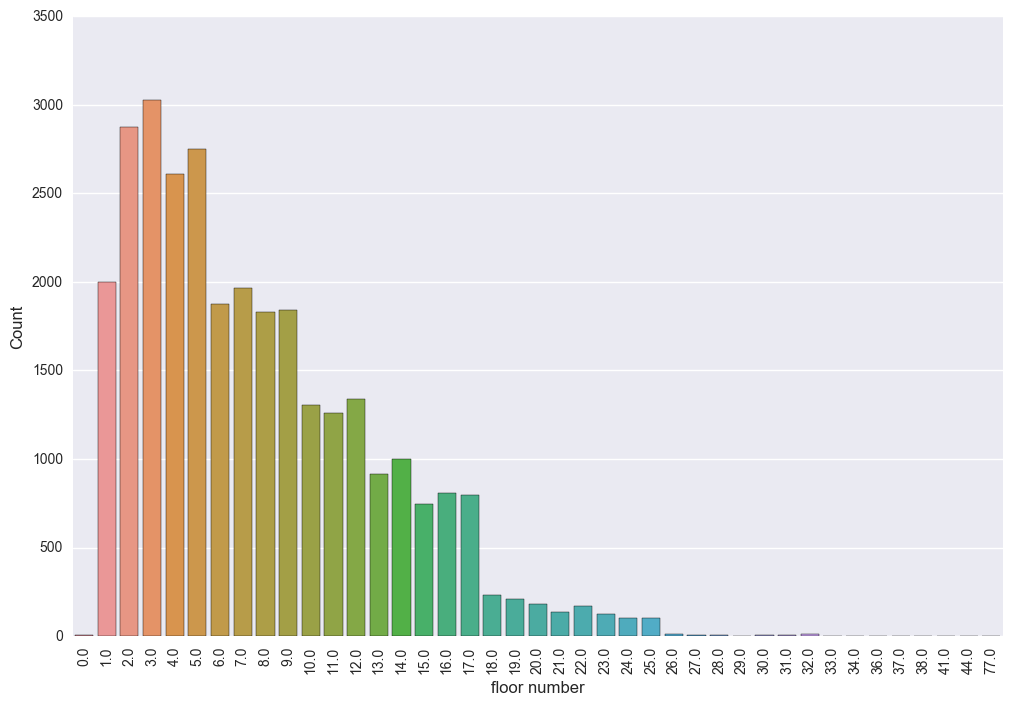

In [31]:
plt.figure(figsize=(12,8))
sns.countplot(x="floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

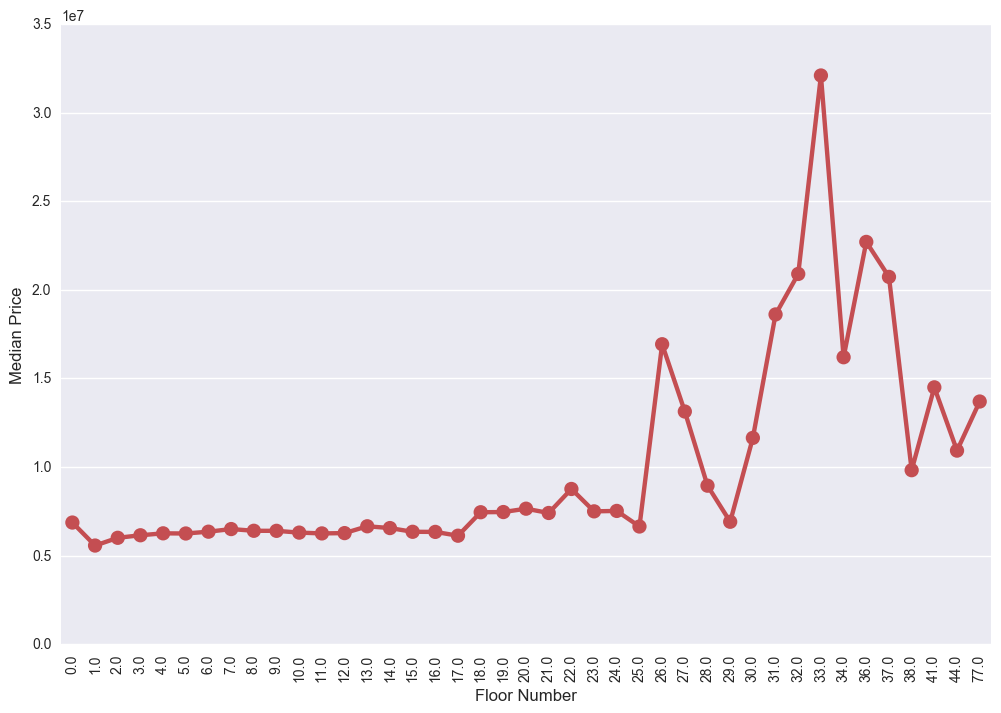

In [32]:
grouped_df = train_df.groupby('floor')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize =(12,8))
sns.pointplot(grouped_df.floor.values, grouped_df.price_doc.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Floor Number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

This shows an overall increasing trend (individual houses seems to be costlier as well - check price of 0 floor houses). A sudden increase in the house price is also observed at floor 18. The tallest building in Russia is 101 floors!!!

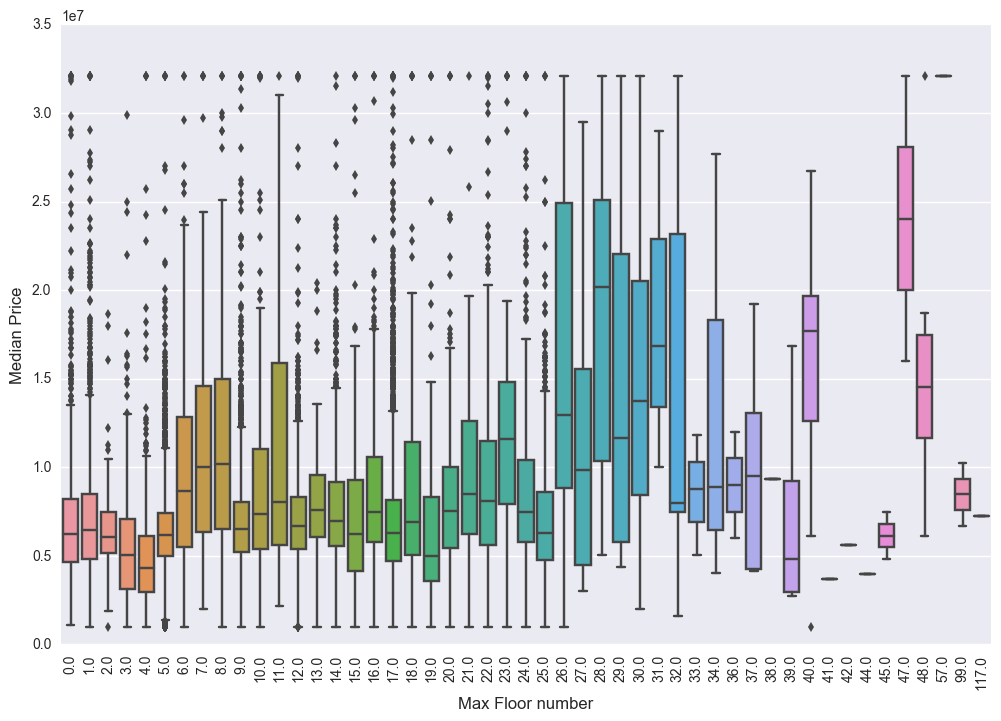

In [33]:
plt.figure(figsize=(12,8))
sns.boxplot(x="max_floor", y="price_doc", data=train_df)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Max Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

# This Ends the first Kernel. Going on to check out Shu's Data Cleaning 

In [25]:
import pandas as pd
from pandas.io.json import build_table_schema
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import scipy as sp
import os
import xgboost as xgb
#import visualization as vis
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
pd.set_option('display.max_columns', 500)
DIR_PATH = './'

In [26]:
train_raw =  pd.read_csv(os.path.join(DIR_PATH,'train.csv'),
                        header='infer',
                        index_col='id',
                        parse_dates=['timestamp'])
test_raw = pd.read_csv(os.path.join(DIR_PATH, 'test.csv'),
                       header='infer',
                       index_col = 'id',
                       parse_dates=['timestamp'])
macro = pd.read_csv(os.path.join(DIR_PATH, 'macro.csv'),
                   header='infer')

# Data Understanding and Data Preparation

In [27]:
train_schema = pd.DataFrame(build_table_schema(train_raw)['fields'])

In [28]:
train_schema.head(10)

,name,type
0,id,integer
1,timestamp,datetime
2,full_sq,integer
3,life_sq,number
4,floor,number
5,max_floor,number
6,material,number
7,build_year,number
8,num_room,number
9,kitch_sq,number


In [29]:
macro_schema = pd.DataFrame(build_table_schema(macro)['fields'])
macro_schema.head() # Note the timestamp here is a string and not a datetime object. This would effect any type of join

,name,type
0,index,integer
1,timestamp,string
2,oil_urals,number
3,gdp_quart,number
4,gdp_quart_growth,number


In [39]:
list(train_raw.columns.values)

['timestamp',
 'full_sq',
 'life_sq',
 'floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state',
 'product_type',
 'sub_area',
 'area_m',
 'raion_popul',
 'green_zone_part',
 'indust_part',
 'children_preschool',
 'preschool_quota',
 'preschool_education_centers_raion',
 'children_school',
 'school_quota',
 'school_education_centers_raion',
 'school_education_centers_top_20_raion',
 'hospital_beds_raion',
 'healthcare_centers_raion',
 'university_top_20_raion',
 'sport_objects_raion',
 'additional_education_raion',
 'culture_objects_top_25',
 'culture_objects_top_25_raion',
 'shopping_centers_raion',
 'office_raion',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'full_all',
 'male_f',
 'female_f',
 'young_all',
 'young_male',
 'young_female',
 'work_all',
 'work_male',
 'work_female',
 'ekder_all',
 'ekd

In [100]:
## start from the top 20 + timestamp features first found from the last kernal
property_features = ['timestamp', 'full_sq', 'life_sq', 'floor', 
                    'max_floor', 'material', 'build_year', 'num_room',
                    'kitch_sq', 'state', 'product_type', 'sub_area', 
                    'price_doc']

# ['timestamp','full_sq','life_sq','floor','max_floor','material','build_year','num_room','kitch_sq','state','product_type',
# 'sub_area','area_m','raion_popul','green_zone_part','indust_part','children_preschool','preschool_quota',
# 'preschool_education_centers_raion','children_school','school_quota','school_education_centers_raion',
# 'school_education_centers_top_20_raion','hospital_beds_raion','healthcare_centers_raion','university_top_20_raion',
# 'sport_objects_raion','additional_education_raion','culture_objects_top_25','culture_objects_top_25_raion',
# 'shopping_centers_raion','office_raion','thermal_power_plant_raion','incineration_raion','oil_chemistry_raion',
# 'radiation_raion','railroad_terminal_raion','big_market_raion','nuclear_reactor_raion', 'detention_facility_raion','price_doc']

top_features =['timestamp','full_sq','life_sq','floor','build_year','max_floor',
               'kitch_sq', 'num_room', 'state', 'kindergarten_km', 'green_zone_km',
               'school_km', 'metro_min_avto', 'public_healthcare_km',
               'sub_area', 'industrial_km',
               'metro_min_walk',
               'railroad_km','swim_pool_km',
               'material','price_doc']

train = train_raw[top_features]
test = test_raw[top_features[:-1]]
train.head()

,timestamp,full_sq,life_sq,floor,build_year,max_floor,kitch_sq,num_room,state,kindergarten_km,green_zone_km,school_km,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,railroad_km,swim_pool_km,material,price_doc
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,0.145700,0.600973,0.177975,2.590241,0.974743,Bibirevo,1.080934,13.575119,1.305159,3.065047,NaN,5850000
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,0.147754,0.065321,0.273345,0.936700,1.477723,Nagatinskij Zaton,0.966479,7.620630,0.694536,2.000154,NaN,6000000
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,0.049102,0.453172,0.158072,2.120999,0.097144,Tekstil'shhiki,0.939275,17.351515,0.700691,1.239304,NaN,5700000
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,0.179441,0.106125,0.236455,1.489049,2.163735,Mitino,0.451173,11.565624,1.999265,1.950317,NaN,13100000
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,0.247901,0.236214,0.376838,1.257186,1.121703,Basmannoe,0.392871,8.266305,0.084113,2.544696,NaN,16331452


## Looking at the Target Parameter Distribution

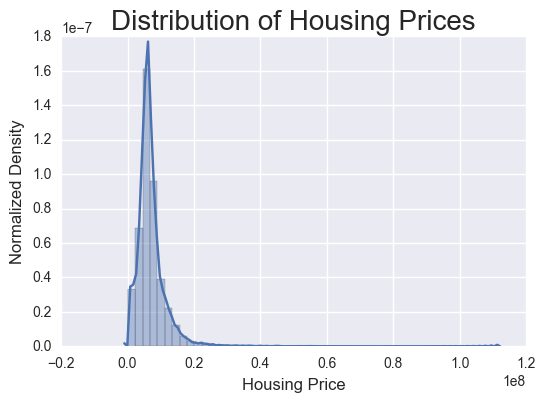

In [50]:
sns.distplot(train.price_doc.values, bins=50, kde = True)
plt.xlabel("Housing Price",fontsize = 12)
plt.title("Distribution of Housing Prices", fontsize = 20)
plt.ylabel("Normalized Density", fontsize = 12)

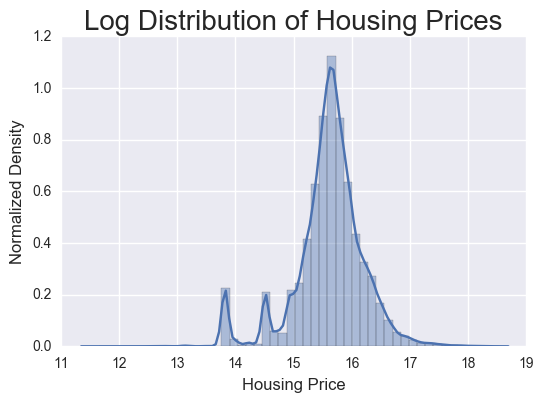

In [51]:
sns.distplot(np.log(train.price_doc.values), bins=50, kde = True)
plt.xlabel("Housing Price",fontsize = 12)
plt.title("Log Distribution of Housing Prices", fontsize = 20)
plt.ylabel("Normalized Density", fontsize = 12)

In [52]:
train[['price_doc','material']].head()

,price_doc,material
id,,
1,5850000,NaN
2,6000000,NaN
3,5700000,NaN
4,13100000,NaN
5,16331452,NaN


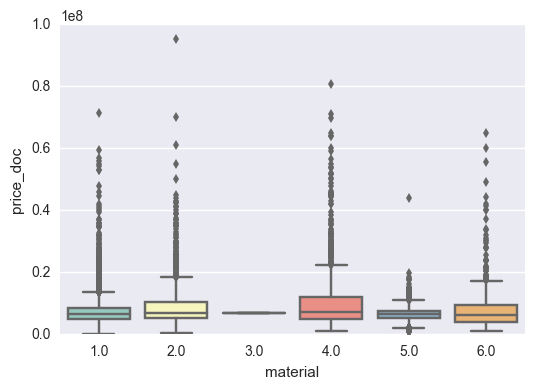

In [57]:
sns.boxplot(x='material', y='price_doc', data=train, palette='Set3')

In [25]:
print(train['material'].value_counts(dropna=False))
print(test['material'].value_counts(dropna=False))

 1.0    14197
NaN      9572
 2.0     2993
 5.0     1561
 4.0     1344
 6.0      803
 3.0        1
Name: material, dtype: int64
1    5241
2     958
4     619
5     487
6     356
3       1
Name: material, dtype: int64


In [58]:
train.loc[train['material'] == 3, 'material'] = np.nan
test.loc[test['material'] == 3, 'material'] = np.nan

/Users/yogadude/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [59]:
print(train['state'].value_counts(dropna=False))
print(test['state'].value_counts(dropna=False))

NaN      13559
 2.0      5844
 3.0      5790
 1.0      4855
 4.0       422
 33.0        1
Name: state, dtype: int64
 2.0    2662
 1.0    2266
 3.0    1913
NaN      694
 4.0     127
Name: state, dtype: int64


In [60]:
train.loc[train['state'] == 33, 'state'] = 3

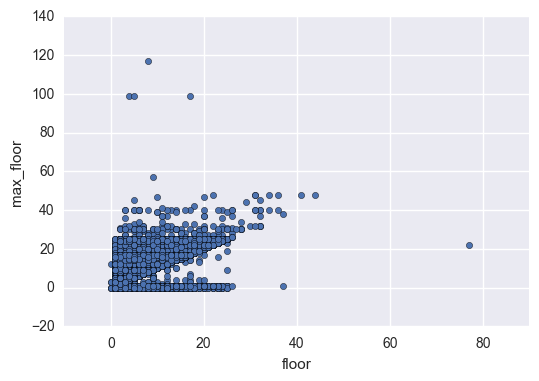

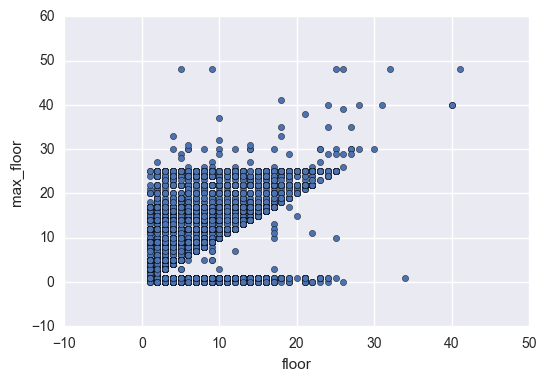

In [61]:
train.plot.scatter(x='floor', y='max_floor')
test.plot.scatter(x='floor', y='max_floor')

In [62]:
train.loc[train['max_floor'] > 60]

,timestamp,full_sq,life_sq,floor,build_year,max_floor,kitch_sq,num_room,state,kindergarten_km,green_zone_km,school_km,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,railroad_km,swim_pool_km,material,price_doc
id,,,,,,,,,,,,,,,,,,,,,
20725,2014-07-10,47,47.0,4.0,NaN,99.0,1.0,1.0,NaN,1.005061,0.699127,0.331429,3.477443,0.520465,Pokrovskoe Streshnevo,0.000000,30.038328,0.546508,4.272625,2.0,10238400
21737,2014-08-21,71,71.0,5.0,NaN,99.0,9.0,2.0,NaN,1.075395,0.294153,1.690124,2.523793,1.811202,Poselenie Moskovskij,0.437857,21.368381,1.720822,4.240410,6.0,8484365
21855,2014-08-25,46,46.0,17.0,NaN,99.0,9.0,3.0,NaN,3.122004,0.595237,3.382934,6.831863,5.143469,Poselenie Sosenskoe,0.086297,70.262575,3.852787,8.793676,6.0,6670000
25943,2014-12-06,63,63.0,8.0,NaN,117.0,1.0,2.0,1.0,1.048962,0.189089,0.269716,1.482746,2.608162,Tverskoe,2.640803,13.459068,2.566044,1.421099,1.0,7239838


In [63]:
train.loc[train['max_floor'] == 117, 'max_floor'] = 17
train.loc[train['max_floor'] > 60, 'max_floor'] = np.nan

In [64]:
train.loc[train['floor'] > 60]

,timestamp,full_sq,life_sq,floor,build_year,max_floor,kitch_sq,num_room,state,kindergarten_km,green_zone_km,school_km,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,railroad_km,swim_pool_km,material,price_doc
id,,,,,,,,,,,,,,,,,,,,,
23587,2014-10-15,57,33.0,77.0,1986.0,22.0,10.0,2.0,3.0,0.171341,0.223338,0.38909,3.038343,0.561219,Lomonosovskoe,1.004353,23.624139,4.364614,1.506392,1.0,13700000


In [65]:
train.loc[train['floor'] == 77, 'floor'] = 7

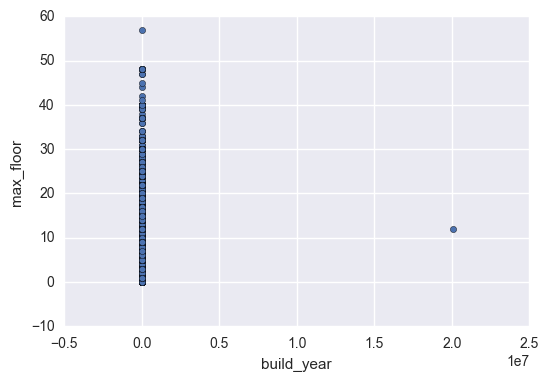

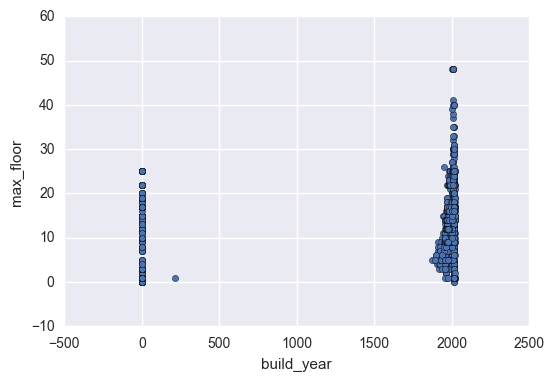

In [67]:
train.plot.scatter(x='build_year', y='max_floor')
test.plot.scatter(x='build_year', y='max_floor')

In [68]:
train['build_year'].value_counts(dropna=False).sort_index()

 0.0             530
 1.0             368
 3.0               2
 20.0              1
 71.0              1
 215.0             1
 1691.0            1
 1860.0            2
 1876.0            1
 1886.0            1
 1890.0            5
 1895.0            1
 1896.0            2
 1900.0            2
 1904.0            1
 1905.0            1
 1906.0            1
 1907.0            2
 1910.0            5
 1911.0            1
 1912.0            5
 1914.0            3
 1915.0            5
 1917.0           16
 1920.0            1
 1924.0            3
 1925.0            1
 1926.0            8
 1927.0           10
 1928.0           12
               ...  
 1992.0          139
 1993.0          115
 1994.0          160
 1995.0          149
 1996.0          162
 1997.0          139
 1998.0          141
 1999.0          125
 2000.0          130
 2001.0          177
 2002.0          214
 2003.0          193
 2004.0          220
 2005.0          176
 2006.0          242
 2007.0          219
 2008.0      

In [69]:
train.loc[train['build_year'] == 20052009, 'build_year'] = 2009
train.loc[train['build_year'] == 4965, 'build_year'] = 1965
train.loc[train['build_year'] == 71, 'build_year'] = 1971
train.loc[train['build_year'] < 1800, 'build_year'] = np.nan

In [70]:
test['build_year'].value_counts(dropna=False).sort_index()

 0.0        369
 1.0        187
 2.0          1
 215.0        1
 1875.0       1
 1890.0       2
 1895.0       1
 1898.0       1
 1902.0       1
 1905.0       1
 1906.0       1
 1908.0       1
 1910.0       1
 1911.0       3
 1912.0       1
 1914.0       2
 1917.0       3
 1924.0       1
 1926.0       8
 1927.0       3
 1928.0       6
 1929.0       4
 1930.0       3
 1931.0       3
 1932.0       3
 1933.0       1
 1935.0       1
 1937.0       5
 1938.0       3
 1939.0       3
           ... 
 1991.0      28
 1992.0      56
 1993.0      39
 1994.0      49
 1995.0      40
 1996.0      44
 1997.0      58
 1998.0      46
 1999.0      53
 2000.0      56
 2001.0      63
 2002.0      65
 2003.0      61
 2004.0      66
 2005.0      65
 2006.0      92
 2007.0      46
 2008.0      74
 2009.0      58
 2010.0      47
 2011.0      61
 2012.0      74
 2013.0     260
 2014.0     199
 2015.0     259
 2016.0     400
 2017.0     413
 2018.0      30
 2019.0       5
NaN        1049
Name: build_year, Length

In [71]:
test.loc[test['build_year'] < 1800, 'build_year'] = np.nan

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12519b110>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x110389e50>]], dtype=object)

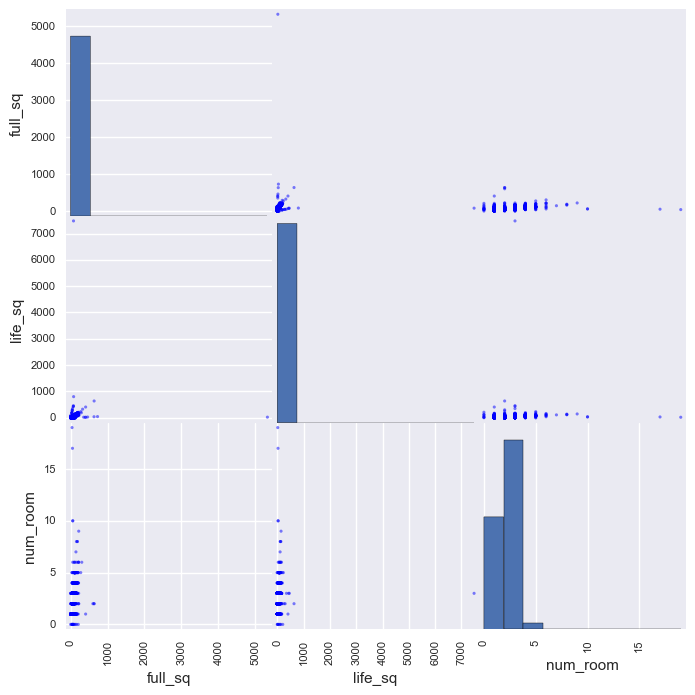

In [72]:
scatter_matrix(train.loc[:, ['full_sq', 'life_sq', 'num_room']], 
               figsize=(8, 8), 
               diagonal='hist')

In [73]:
train.loc[train['num_room'] > 9]

,timestamp,full_sq,life_sq,floor,build_year,max_floor,kitch_sq,num_room,state,kindergarten_km,green_zone_km,school_km,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,railroad_km,swim_pool_km,material,price_doc
id,,,,,,,,,,,,,,,,,,,,,
11624,2013-10-28,40,19.0,17.0,2011.0,17.0,7.0,19.0,3.0,1.551697,0.346562,1.063754,5.387602,4.807869,Poselenie Vnukovskoe,1.854658,53.937418,1.425721,5.276651,1.0,2630000
17767,2014-04-23,58,34.0,1.0,1992.0,2.0,10.0,10.0,2.0,0.306421,0.158759,0.250213,28.375876,0.874921,Krjukovo,0.583422,265.148970,0.698560,7.114352,1.0,6000000
26716,2014-12-18,51,30.0,14.0,1984.0,17.0,8.0,17.0,3.0,0.663373,0.042211,0.129363,2.742032,1.481760,Obruchevskoe,0.346409,21.544815,5.135935,1.156830,1.0,13150000
29175,2015-04-16,59,33.0,20.0,2000.0,22.0,10.0,10.0,3.0,0.206135,0.118084,0.229004,1.511780,0.148872,Mar'ino,1.779460,14.513092,2.468642,2.864970,1.0,11000000


In [74]:
train.loc[train['num_room'] > 9, 'num_room'] = np.nan
train.loc[train['num_room'] < 1, 'num_room'] = np.nan

In [75]:
train.loc[train['full_sq'] > 300]

,timestamp,full_sq,life_sq,floor,build_year,max_floor,kitch_sq,num_room,state,kindergarten_km,green_zone_km,school_km,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,railroad_km,swim_pool_km,material,price_doc
id,,,,,,,,,,,,,,,,,,,,,
129,2011-10-15,325,325.0,7.0,NaN,NaN,NaN,NaN,NaN,0.161408,0.317645,0.369984,1.503550,1.823912,Ivanovskoe,0.867218,12.846671,0.528868,3.326037,NaN,5000000
1481,2012-03-11,353,20.0,5.0,NaN,NaN,NaN,NaN,NaN,0.693142,0.282887,0.492894,1.461016,2.326553,Solncevo,0.263754,11.804288,0.228997,0.543969,NaN,4750000
1613,2012-03-21,394,17.0,11.0,NaN,NaN,NaN,NaN,NaN,0.294243,0.479923,0.243053,2.451078,0.861904,Ljublino,1.600583,18.131493,2.770051,3.342112,NaN,1050000
2428,2012-06-07,412,17.0,6.0,NaN,NaN,NaN,NaN,NaN,0.236231,0.218199,0.068637,1.894180,0.664952,Filevskij Park,0.457346,8.184794,0.326426,2.340215,NaN,6117000
2783,2012-07-06,729,44.0,12.0,NaN,NaN,NaN,NaN,NaN,0.136485,0.023740,0.426871,2.685885,0.564859,Troparevo-Nikulino,1.415226,22.127146,1.383085,2.488351,NaN,13250000
3530,2012-09-07,5326,22.0,13.0,NaN,NaN,NaN,NaN,NaN,0.780191,0.499398,0.699257,4.907833,2.149384,Birjulevo Vostochnoe,0.214503,28.439791,0.841827,3.381655,NaN,6868818
3599,2012-09-12,388,NaN,9.0,NaN,NaN,NaN,NaN,NaN,1.553718,1.678090,0.480208,0.913144,3.983903,Nekrasovka,0.754633,4.431607,2.832923,7.361991,NaN,3899400
5947,2013-02-07,634,38.0,3.0,NaN,NaN,NaN,NaN,NaN,0.025172,0.121641,0.353390,1.746993,1.566321,Lianozovo,1.063524,8.067791,1.426593,2.029415,NaN,10200000
7210,2013-04-10,461,27.0,2.0,NaN,NaN,NaN,NaN,NaN,0.124746,0.043799,0.206264,2.695339,1.496204,Vyhino-Zhulebino,0.678648,24.727498,1.851885,5.805225,NaN,5750000


In [76]:
train.loc[3530, 'full_sq'] = 5326/100
train.loc[train['full_sq'] > 310, 'full_sq'] = train.loc[train['full_sq'] > 310, 'full_sq']/10
train.loc[train['full_sq'] < 2, 'full_sq'] = np.nan

In [77]:
train.loc[(train['full_sq'] < train['life_sq']) & (train['life_sq'] > 100)]

,timestamp,full_sq,life_sq,floor,build_year,max_floor,kitch_sq,num_room,state,kindergarten_km,green_zone_km,school_km,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,railroad_km,swim_pool_km,material,price_doc
id,,,,,,,,,,,,,,,,,,,,,
129,2011-10-15,32.5,325.0,7.0,NaN,NaN,NaN,NaN,NaN,0.161408,0.317645,0.369984,1.503550,1.823912,Ivanovskoe,0.867218,12.846671,0.528868,3.326037,NaN,5000000
1085,2012-02-06,44.0,281.0,6.0,NaN,NaN,NaN,NaN,NaN,0.145700,0.600973,0.177975,2.590241,0.974743,Bibirevo,1.080934,13.575119,1.305159,3.065047,NaN,6200000
1866,2012-04-11,30.0,178.0,4.0,NaN,NaN,NaN,NaN,NaN,0.269328,0.346558,0.794335,2.236106,0.767678,Presnenskoe,0.351631,14.074044,0.315507,1.212228,NaN,5900000
4388,2012-10-25,73.0,426.0,17.0,NaN,NaN,NaN,NaN,NaN,0.394047,0.206908,0.839645,2.932925,1.074027,Vojkovskoe,0.206545,26.013084,0.239221,3.706072,NaN,11918400
6339,2013-03-06,37.0,191.0,5.0,NaN,NaN,NaN,NaN,NaN,0.129729,0.567371,0.325808,1.610394,0.196878,Kosino-Uhtomskoe,0.773620,12.819534,2.181870,3.809855,NaN,5400000
7211,2013-04-10,31.0,195.0,5.0,NaN,NaN,NaN,NaN,NaN,0.106500,0.042814,0.089749,1.984271,2.175881,Cheremushki,1.475904,7.634456,3.269507,2.255684,NaN,6400000
9240,2013-07-16,47.0,301.0,4.0,1973.0,12.0,6.0,2.0,2.0,0.933135,0.384959,0.367718,7.408741,5.096492,Birjulevo Zapadnoe,0.304721,61.776704,0.499376,7.667384,1.0,5600000
9259,2013-07-17,77.0,458.0,12.0,1996.0,16.0,10.0,3.0,3.0,0.521532,0.108477,0.114576,3.032879,0.894559,Jasenevo,1.068575,20.332892,5.578844,0.884038,1.0,13750000
9649,2013-08-06,82.0,802.0,5.0,NaN,NaN,NaN,NaN,NaN,0.379842,0.533126,0.374914,1.974013,0.734476,Chertanovo Juzhnoe,0.683597,6.759876,1.238357,4.755713,NaN,12031350


In [78]:
## changes: life_sq[13549] to life_sq[13549]/100, rest divided by 10, life_sq < 2 to np.nan
train.loc[13549, 'life_sq'] = train.loc[13549, 'life_sq'] / 100
rows = (train['full_sq'] < train['life_sq']) & (train['life_sq'] > 100)
train.loc[rows, 'life_sq'] = train.loc[rows, 'life_sq'] / 10
train.loc[train['life_sq'] < 2, 'life_sq'] = np.nan

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110858190>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11b57c050>]], dtype=object)

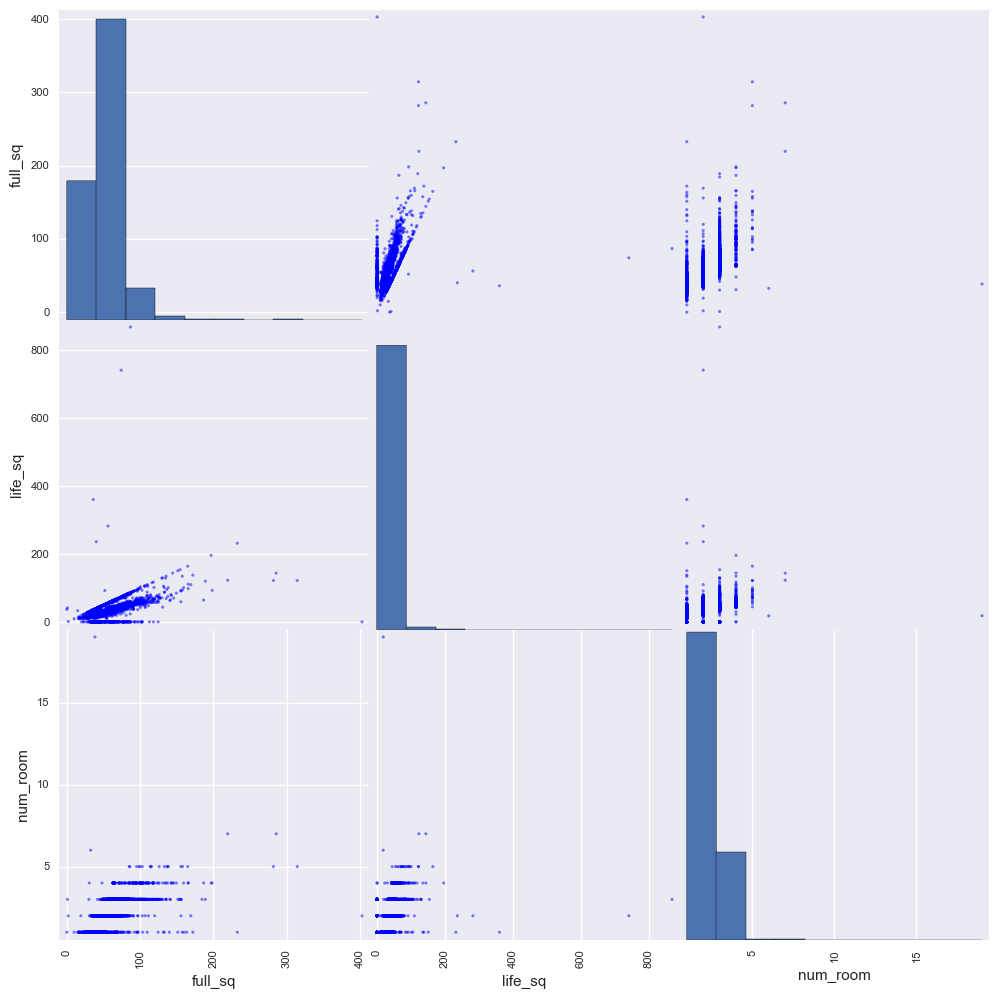

In [79]:
## num_room / full_sq / life_sq (test set)
scatter_matrix(test.loc[:, ['full_sq', 'life_sq', 'num_room']], 
               figsize=(12, 12), 
               diagonal='hist')

In [80]:
test.loc[test['num_room'] > 9, 'num_room'] = np.nan

In [81]:
test.loc[test['full_sq'] > 400, 'full_sq'] = test.loc[test['full_sq'] > 400, 'full_sq'] / 10
test.loc[test['full_sq'] < 3, 'full_sq'] = np.nan

In [82]:
## life_sq
rows = (test['full_sq'] < test['life_sq']) & (test['life_sq'] > 110)
test.loc[rows]

,timestamp,full_sq,life_sq,floor,build_year,max_floor,kitch_sq,num_room,state,kindergarten_km,green_zone_km,school_km,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,railroad_km,swim_pool_km,material
id,,,,,,,,,,,,,,,,,,,,
31075,2015-08-17,74.2,742.0,2,NaN,17,1.0,2.0,1.0,2.982879,0.111993,3.117219,6.190648,6.378398,Poselenie Sosenskoe,0.084083,61.742427,5.608658,6.965529,1.0
32370,2015-10-23,36.1,361.0,14,NaN,14,0.0,1.0,1.0,3.829123,0.207943,4.272721,7.576081,7.171576,Poselenie Sosenskoe,0.678044,71.012576,5.978380,7.758707,4.0
32505,2015-10-30,40.2,237.0,11,2016.0,11,67.0,2.0,1.0,1.007120,0.329011,0.603186,3.179944,2.499325,Horoshevo-Mnevniki,0.597073,15.396633,0.912129,1.414525,1.0
33265,2015-12-01,86.9,869.0,3,NaN,20,0.0,3.0,1.0,1.094714,0.541159,0.292072,1.962813,2.494821,Chertanovo Juzhnoe,0.000000,11.941165,0.722121,4.867104,4.0
35661,2016-02-15,56.3,283.0,7,2014.0,17,8.3,2.0,2.0,0.300839,0.635390,0.351912,1.094442,0.611566,Sokolinaja Gora,0.891761,9.359644,0.421121,0.617028,1.0


In [83]:
test.loc[rows, 'life_sq'] = test.loc[rows, 'life_sq'] / 10
test.loc[test['life_sq'] < 3, 'life_sq'] = np.nan

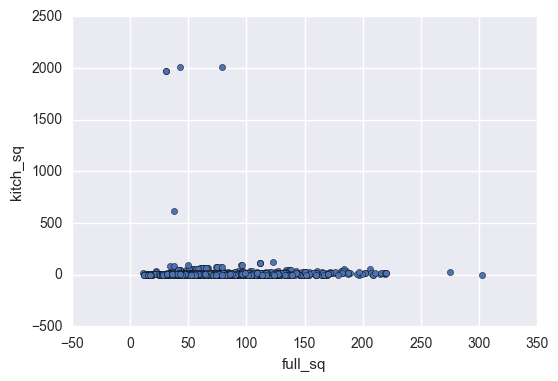

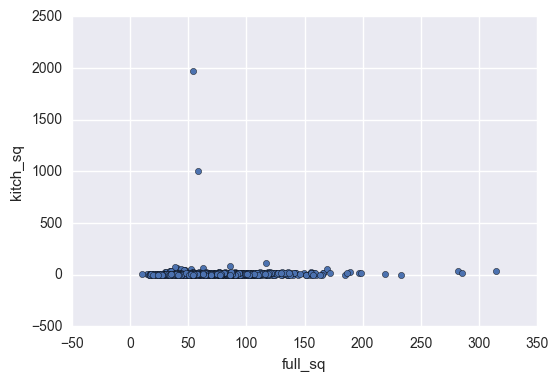

In [84]:
## kitch_sq
train.plot.scatter(x='full_sq', y='kitch_sq')
test.plot.scatter(x='full_sq', y='kitch_sq')

In [85]:
train.loc[(train['kitch_sq'] > train['full_sq']) & (train['kitch_sq'] > 100)]

,timestamp,full_sq,life_sq,floor,build_year,max_floor,kitch_sq,num_room,state,kindergarten_km,green_zone_km,school_km,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,railroad_km,swim_pool_km,material,price_doc
id,,,,,,,,,,,,,,,,,,,,,
10371,2013-09-10,79.0,41.0,5.0,2013.0,17.0,2013.0,3.0,1.0,0.745286,0.456704,0.936324,3.121542,2.992295,Poselenie Voskresenskoe,1.018137,29.242588,1.266142,5.374915,6.0,7281225
11523,2013-10-24,38.0,23.0,11.0,1971.0,14.0,620.0,2.0,2.0,0.187291,0.114137,0.528503,1.861349,2.158187,Novogireevo,1.073451,14.583077,0.146914,2.717764,5.0,6300000
13120,2013-12-14,31.0,19.0,5.0,NaN,1.0,1970.0,1.0,3.0,0.651020,0.100984,0.624749,2.140336,1.240744,Izmajlovo,0.126751,17.805130,0.103390,2.580019,1.0,3650000
21418,2014-08-11,43.0,43.0,3.0,2014.0,1.0,2014.0,1.0,1.0,3.803968,0.490269,3.840841,7.450495,5.696141,Poselenie Sosenskoe,0.120089,73.662835,4.633271,7.958897,1.0,3801200
28737,2015-03-31,31.0,16.0,2.0,1972.0,12.0,1974.0,1.0,3.0,1.865702,0.016858,0.645011,28.671244,4.642274,Matushkino,0.290751,297.044946,1.856171,4.067874,5.0,1000000


In [86]:
train.loc[13120, 'build_year'] = 1970
train.loc[11523, 'kitch_sq'] = train.loc[11523, 'kitch_sq'] / 100
train.loc[train['kitch_sq'] > 200, 'kitch_sq'] = np.nan
train.loc[train['kitch_sq'] < 2, 'kitch_sq'] = np.nan
train.loc[train['kitch_sq'] == train['full_sq'], 'kitch_sq'] = np.nan
train.loc[train['kitch_sq'] == train['life_sq'], 'kitch_sq'] = np.nan

In [87]:
test.loc[(test['kitch_sq'] > test['full_sq']) & (test['kitch_sq'] > 100)]

,timestamp,full_sq,life_sq,floor,build_year,max_floor,kitch_sq,num_room,state,kindergarten_km,green_zone_km,school_km,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,railroad_km,swim_pool_km,material
id,,,,,,,,,,,,,,,,,,,,
31381,2015-09-01,53.9,32.1,3,1968.0,9,1968.0,2.0,2.0,0.303390,0.137351,0.605667,1.354937,1.163130,Severnoe Medvedkovo,0.46839,9.530095,1.852194,5.258979,1.0
36811,2016-03-19,58.5,58.5,15,2017.0,17,1000.0,2.0,NaN,1.721142,0.470201,11.428570,19.402100,16.013178,Poselenie Desjonovskoe,0.32026,195.787660,12.348510,20.274755,1.0


In [88]:
test.loc[test['kitch_sq'] > 200, 'kitch_sq'] = np.nan
test.loc[test['kitch_sq'] < 1.1, 'kitch_sq'] = np.nan
test.loc[test['kitch_sq'] == test['full_sq'], 'kitch_sq'] = np.nan
test.loc[test['kitch_sq'] == test['life_sq'], 'kitch_sq'] = np.nan

In [89]:
vis.corr_plot(train)
vis.corr_plot(test)

NameError: name 'vis' is not defined

In [90]:
train.loc[:, 'sq_metr'] = train.loc[:, ['full_sq','life_sq']].max(axis=1)

/Users/yogadude/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


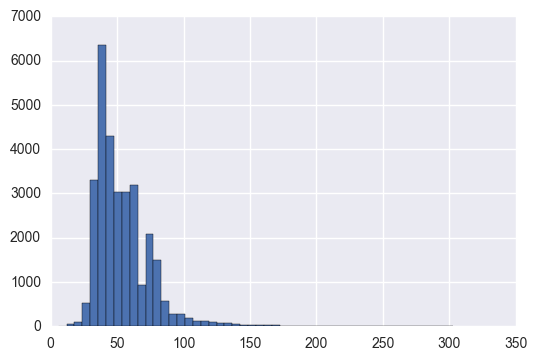

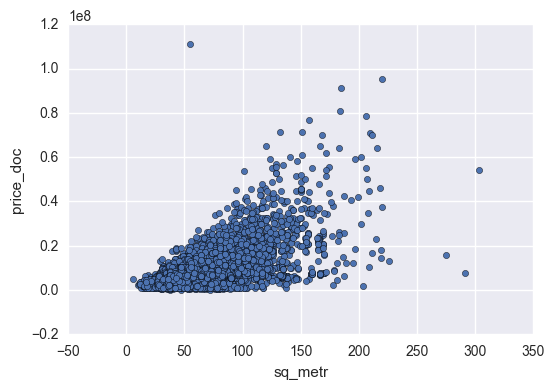

In [91]:
train.loc[:, "sq_metr"].hist(bins=50)
train.plot.scatter(x='sq_metr', y='price_doc')

In [92]:
train = train.drop(train[train['price_doc'] > 1e8].index)

In [93]:
test.loc[:, 'sq_metr'] = test.loc[:, ['full_sq','life_sq']].max(axis=1)

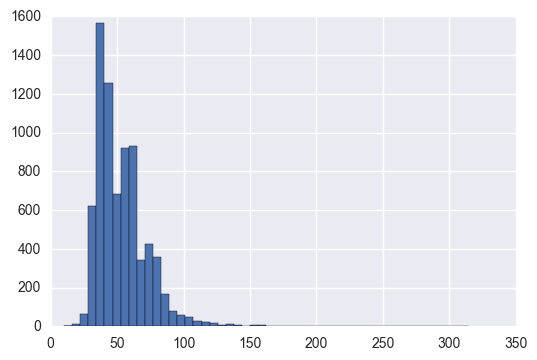

In [94]:
test.loc[:, "sq_metr"].hist(bins=50)

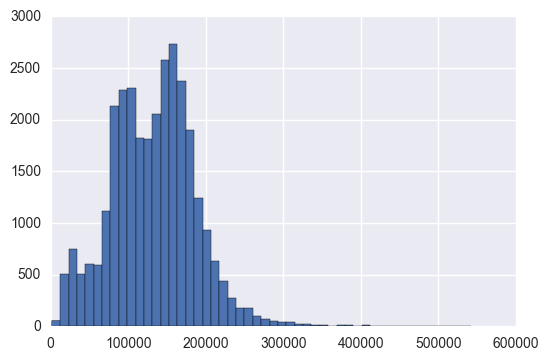

In [96]:
## property unit_price
train.loc[:, 'unit_price'] = train.loc[:, 'price_doc'] / train.loc[:, 'sq_metr']
train.loc[train['unit_price'] > 600000, 'unit_price'] = np.nan
train.loc[:, "unit_price"].hist(bins=50)


In [97]:
train.loc[:, "unit_price"].value_counts(dropna=False).sort_index()

 1388.888889       1
 4255.319149       1
 4788.777778       1
 4857.142857       1
 5000.000000       1
 5256.410256       1
 5368.015152       1
 5738.474576       1
 5903.112500       1
 6000.000000       1
 6024.096386       1
 6039.416058       1
 6186.932584       1
 6275.026316       1
 6329.113924       1
 6500.000000       1
 6896.875000       1
 7080.923077       1
 8088.235294       1
 8389.830508       1
 8474.576271       1
 8780.487805       1
 8958.486486       1
 9000.000000       1
 9090.909091       1
 9210.526316       1
 9433.962264       2
 9611.650485       1
 9615.384615       1
 9677.419355       1
                  ..
 415587.333333     1
 418518.518519     1
 418905.702128     1
 419354.838710     1
 422607.813953     1
 424672.897196     1
 425287.356322     1
 425531.914894     1
 429526.418605     1
 432285.147287     1
 432374.981818     1
 435000.000000     1
 435483.870968     1
 436445.023256     1
 439007.826087     1
 439837.705426     1
 440000.00000

In [103]:
print len(list(train.columns.values))
print 40 * '*'
print len(list(test.columns.values))

21
****************************************
20


In [102]:
train.to_csv('out.csv')